<a href="https://colab.research.google.com/github/nahumsa/DM-Reconstruction/blob/master/Reconstruct%20DM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconstruction of a density matrix

### Import dependencies for Google Colab

In [0]:
! git clone https://github.com/nahumsa/DM-Reconstruction

In [0]:
!pip install qutip

In [3]:
% cd DM-Reconstruction/

/content/DM-Reconstruction


##Import Dependencies

In [0]:
try:
  %tensorflow_version 2.x

except Exception:
  pass
  
import tensorflow as tf

#Set Random Seed for reproduction
tf.random.set_seed(1234)

# Remove warnings
import logging
logging.getLogger('tensorflow').disabled = True

#Use this to not need to initialize tensors outside session
tf.config.experimental_run_functions_eagerly(True)

In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import qutip
from tqdm.notebook import tqdm

## Creating dataset

In [0]:
from Utils.Dataset import create_dataset

samples_train = 5000
states_train, measurements_train, labels_train = create_dataset(samples_train)

samples_test = 3000
states_test, measurements_test, labels_test = create_dataset(samples_test)

In [0]:
from Utils.Dataset import create_x

#Transforming in an np.array
X_train = np.array(create_x(measurements_train))
Y_train = np.array(labels_train)

X_test = np.array(create_x(measurements_test))
Y_test = np.array(labels_test)

#print(f"Shape of the Training: \n X: {X_train.shape}")

# Models

## Using Trace distance as a loss function

In [0]:
from Models.TVAE import TraceVAE

ZDIM = 20
input_dim = X_train.shape[1]
hidden_dims = [64,128,256]
batchsize = 32

vae = TraceVAE(original_dim=input_dim,
               intermediate_dim=hidden_dims,
               latent_dim=ZDIM)

# Optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

vae.compile(optimizer=optimizer)

# Prepare a dataset.
dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.shuffle(buffer_size=1024).batch(batchsize)

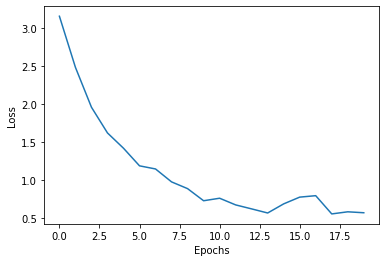

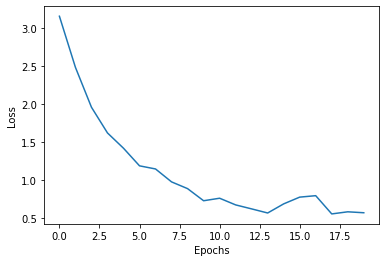

In [10]:
from Utils.Plotter import PeriodicPlotter

r_loss = 10.
beta = 1e-2
epochs = 20

# Periodic Plotter for loss
plotter = PeriodicPlotter(sec=5, xlabel='Epochs', ylabel='Loss')

loss_epochs = vae.training(dataset, epochs, r_loss, beta, Plotter=plotter)

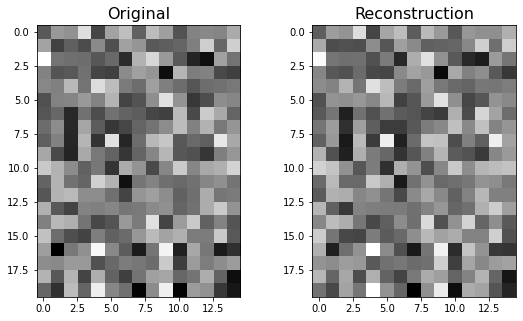

In [12]:
fig = plt.figure(figsize=(14,5))
gs = fig.add_gridspec(1, 3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])


ax1.imshow((X_train[0:20]), cmap="gray")
ax1.set_title('Original', size=16)

ax2.imshow(vae.predict(X_train[0:20]), cmap="gray")
ax2.set_title('Reconstruction', size=16)

#_, _, z = vae.encoder(X_test)
#z = z.numpy()

#ax3 = fig.add_subplot(gs[0, 2])
#ims = ax3.scatter(z[:,0], z[:,1], c=Y_test)
#ax3.set_title('Latent Space', size=16)
#plt.colorbar(ims, ax=ax3)

plt.show()

# Denoising measurements with gaussian error

In [14]:
from Utils.Dataset import create_x
n_measurements = len(measurements_train[0])
noise_factor = 1.

#Transforming in an np.array
X_train = np.array(create_x(measurements_train)) + noise_factor*np.random.randn(samples_train,n_measurements)
Y_train = np.array(create_x(measurements_train))
labels_train = np.array(labels_train)

X_test = np.array(create_x(measurements_test)) + noise_factor*np.random.randn(samples_test,n_measurements)
Y_test = np.array(create_x(measurements_test))
labels_test = np.array(labels_test)

print(f"Shape of the Training: \n X: {X_train.shape} \n Y: {Y_train.shape}")

Shape of the Training: 
 X: (5000, 15) 
 Y: (5000, 15)


In [0]:
from Models.TVAE import TraceVAE
from Utils.QMetrics import trace_loss

class Denoise(TraceVAE):
  def __init__(self,
               original_dim,
               intermediate_dim,
               latent_dim,               
               **kwargs):    

    super(Denoise, self).__init__(original_dim,
                                   intermediate_dim,
                                   latent_dim)
  def training_step(self, x, y, r_loss, beta):
    """Training step for the VAE.
  
    Parameters
    -------------------------------------------
    x: Data with noise
    y: Data without noise
    VAE(tf.keras.Model): Variational Autoencoder model. 
    optimizer(tf.keras.optimizer): Optimizer used.  
    r_loss(float): Parameter controlling reconstruction loss.
    beta(float): Parameter controlling the KL divergence.

    Return:
    Loss(float): Loss value of the training step.

    """
    with tf.GradientTape() as tape:
      reconstructed = self(x)  # Compute input reconstruction.
      # Compute loss.
      print(len(y))
      loss = trace_loss(y, reconstructed)
      kl = sum(self.losses)
      loss = r_loss * loss + beta*kl  
    
    # Update the weights of the VAE.
    grads = tape.gradient(loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))    
    return loss

  def training(self, dataset,
             epochs, r_loss, beta,              
             Plotter=None):
    """ Training of the Variational Autoencoder for a 
    tensorflow.dataset.

    Parameters
    -------------------------------------------
    dataset(tf.data.Dataset): Dataset of the data.
    VAE(tf.keras.Model): Variational Autoencoder model.
    epochs(int): Number of epochs.
    r_loss(float): Parameter controlling reconstruction loss.
    beta(float): Parameter controlling the KL divergence.  
    Plotter(object): Plotter object to show how the training is
                    going (Default=None).

    """

    losses = []
    epochs = range(epochs)

    for i in tqdm(epochs, desc='Epochs'):
      losses_epochs = []
      for step, (x, y) in enumerate(dataset):

        loss = self.training_step(x, y, r_loss, beta)
  
        # Logging.
        losses_epochs.append(float(loss))
      losses.append(np.mean(losses_epochs))
    
      if Plotter != None:
        Plotter.plot(losses)

    return losses 

In [0]:
ZDIM = 20
input_dim = X_train.shape[1]
hidden_dims = [64,128,256]
batchsize = 512

denoising = Denoise(original_dim=input_dim,
               intermediate_dim=hidden_dims,
               latent_dim=ZDIM)

# Optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

denoising.compile(optimizer=optimizer)

In [0]:
# Prepare a dataset.
dataset = tf.data.Dataset.from_tensor_slices((X_train,Y_train))
dataset = dataset.shuffle(buffer_size=1024).batch(batchsize)

In [0]:
from Utils.Plotter import PeriodicPlotter

r_loss = 10.
beta = 1e-2
epochs = 1

# Periodic Plotter for loss
plotter = PeriodicPlotter(sec=5, xlabel='Epochs', ylabel='Loss')

loss_epochs = denoising.training(dataset, epochs, r_loss, beta, Plotter=plotter)

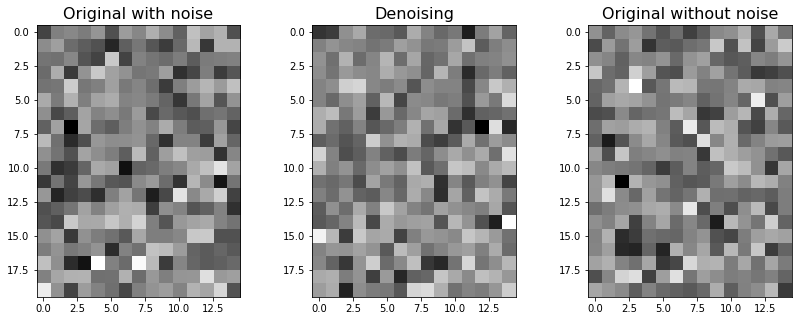

In [19]:
fig = plt.figure(figsize=(14,5))
gs = fig.add_gridspec(1, 3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

ax1.imshow((X_test[0:20]), cmap="gray")
ax1.set_title('Original with noise', size=16)

ax2.imshow(denoising.predict(X_test[0:20]), cmap="gray")
ax2.set_title('Denoising', size=16)

ax3.imshow((Y_test[0:20]), cmap="gray")
ax3.set_title('Original without noise', size=16)
plt.show()

# Trace distance with separable states

In [0]:
from Utils.Dataset import create_dataset

samples_train = 5000
states_train, measurements_train, labels_train = create_dataset(samples_train)

samples_test = 3000
states_test, measurements_test, labels_test = create_dataset(samples_test)

In [0]:
from Utils.Dataset import create_x

#Transforming in an np.array
X_train = np.array(create_x(measurements_train))
Y_train = np.array(labels_train)

X_test = np.array(create_x(measurements_test))
Y_test = np.array(labels_test)

# Prepare a dataset.
dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.shuffle(buffer_size=1024).batch(batchsize)

In [0]:
from Models.TVAE import TraceVAE
from Utils.QMetrics import trace_loss, create_2qubit_density_mat
from Utils.Dataset import generate_separable

class Entanglement(TraceVAE):
  def __init__(self,
               original_dim,
               intermediate_dim,
               latent_dim,               
               **kwargs):    

    super(Entanglement, self).__init__(original_dim,
                                   intermediate_dim,
                                   latent_dim)
    
  def training_step(self, x, r_loss, beta):
    """Training step for the VAE.
  
    Parameters
    -------------------------------------------
    x: Data.
    VAE(tf.keras.Model): Variational Autoencoder model. 
    optimizer(tf.keras.optimizer): Optimizer used.  
    r_loss(float): Parameter controlling reconstruction loss.
    beta(float): Parameter controlling the KL divergence.

    Return:
    Loss(float): Loss value of the training step.

    """
    with tf.GradientTape() as tape:
      reconstructed = self(x)  # Compute input reconstruction.
      # Compute loss.

      sep_states, sep_measurements = generate_separable(len(x))
      sep_measurements = tf.Variable(create_x(sep_measurements), dtype=tf.dtypes.complex64)      
      loss = trace_loss(sep_measurements, reconstructed)
      kl = sum(self.losses)
      loss = r_loss * loss + beta*kl  
    
    # Update the weights of the VAE.
    grads = tape.gradient(loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))    
    
    return loss


In [0]:
ZDIM = 20
input_dim = X_train.shape[1]
hidden_dims = [64,128,256]
batchsize = 512

ent = Entanglement(original_dim=input_dim,
               intermediate_dim=hidden_dims,
               latent_dim=ZDIM)

# Optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

ent.compile(optimizer=optimizer)

In [0]:
from Utils.Plotter import PeriodicPlotter

r_loss = 10.
beta = 1e-2
epochs = 200

# Periodic Plotter for loss
plotter = PeriodicPlotter(sec=5, xlabel='Epochs', ylabel='Loss')

loss_epochs = ent.training(dataset, epochs, r_loss, beta, Plotter=plotter)

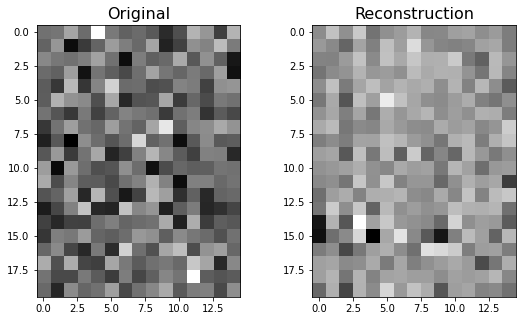

In [134]:
fig = plt.figure(figsize=(14,5))
gs = fig.add_gridspec(1, 3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])


ax1.imshow((X_train[0:20]), cmap="gray")
ax1.set_title('Original', size=16)

ax2.imshow(ent.predict(X_train[0:20]), cmap="gray")
ax2.set_title('Reconstruction', size=16)

#_, _, z = ent.encoder(X_test)
#z = z.numpy()

#ax3 = fig.add_subplot(gs[0, 2])
#ims = ax3.scatter(z[:,0], z[:,1], c=Y_test)
#ax3.set_title('Latent Space', size=16)
#plt.colorbar(ims, ax=ax3)

plt.show()

### Evaluating entangled and separable states


Separable

In [135]:
from Utils.Dataset import generate_separable
n_meas = 1000
state, meas = generate_separable(n_meas)
meas = np.array(create_x(meas))
print(f'Trace loss: {trace_loss(ent(meas),meas)}')

Trace loss: 0.2567058801651001



Entangled

In [136]:
from Utils.Dataset import generate_entangled
n_meas = 1000
state, meas = generate_entangled(n_meas)
meas = np.array(create_x(meas))
print(f'Trace loss: {trace_loss(ent(meas),meas)}')

Trace loss: 0.3427059054374695
